In [34]:
import gym
from matplotlib import pyplot as plt
import numpy as np
import time

In [36]:
env=gym.make('MountainCar-v0')

In [37]:
# 显示一般环境信息
print('观测空间={}'.format(env.observation_space))
print(env.observation_space.low,env.observation_space.high)
print('动作空间={}'.format(env.action_space))
print('位置范围={}'.format((env.min_position,env.max_position)))
print('速度范围={}'.format((-env.max_speed,env.max_speed)))
print('目标位置={}'.format(env.goal_position))

观测空间=Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
[-1.2  -0.07] [0.6  0.07]
动作空间=Discrete(3)
位置范围=(-1.2, 0.6)
速度范围=(-0.07, 0.07)
目标位置=0.5


### 6-2 总是向右施加力的智能体

/home/zlz/anaconda3/envs/RL_gym/lib/python3.9/site-packages/gym/core.py:57: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


shibai
-200.0


/tmp/ipykernel_9934/1845608192.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


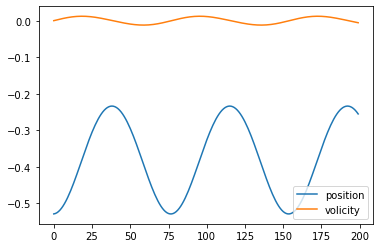

In [24]:

positions,volicities=[],[]
observation=env.reset()
total_reward=0
while 1:
    env.render()
    positions.append(observation[0])
    volicities.append(observation[1])
    next_observation,reward,done,info=env.step(2)
    total_reward += reward
    if done:
        break
    observation=next_observation
if next_observation[0]>0.5:
    print('成功')
else:
    print('shibai')
env.close()
print(total_reward)
fig,ax=plt.subplots()
ax.plot(positions,label='position')
ax.plot(volicities,label='volicity')
ax.legend()
fig.show();

### 6-3 砖瓦编码的实现

In [38]:
class TileCoder:
    def __init__(self,layers,features):
        self.layers=layers
        self.features=features
        self.codebook={}
    
    def get_feature(self,codeword):
        if codeword in self.codebook:
            return self.codebook[codeword]
        count=len(self.codebook)
        if count>=self.features:
            return hash(codeword)
        else:
            self.codebook[codeword]=count
        return count
    
    def __call__(self,floats=(),ints=()):
        dim=len(floats)
        scaled_floats=tuple(f*self.layers*self.layers for f in floats)
        features=[]
        for layer in range(self.layers):
            codeword=(layer,)+tuple(int((f+(1+dim*i)*layer)/self.layers) for i,f in enumerate(scaled_floats)) + ints
            feature = self.get_feature(codeword)
            features.append(feature)
        return features


### 6-4 函数近似SARSA算法智能体

In [39]:
class SARSAAgent:
    def __init__(self,env,gamma=0.9,learning_rate=0.1,epsilon=0.01,layers=8,features=1893):
        self.gamma=gamma#折扣
        self.learning_rate=learning_rate#学习率
        self.epsilon=epsilon#探索
        self.action_n=env.action_space.n#动作数
        self.obs_low=env.observation_space.low
        self.obs_scale=env.observation_space.high-env.observation_space.low#观测空间范围
        self.encoder=TileCoder(layers,features)#砖瓦编码器
        self.w=np.zeros(features)#权重
    
    def encode(self,observation,action): # 编码
        states=tuple((observation-self.obs_low)/self.obs_scale)
        actions=tuple(action,)
        return self.encoder(states,actions)
    
    def get_q(self,observation,action): #动作价值
        features=self.encode(observation,action)
        return self.w[features].sum()

    def decide(self,observation): #决策
        if np.random.rand()<self.epsilon:
            return np.random.randint(self.action_n)
        else:
            qs=[self.get_q(observation,action) for action in range(self.action_n)]
            return np.argmax(qs)
    
    def learn(self,observation,action,reward,done,next_observation,next_action):# 学习
        u=reward+self.gamma*self.get_q(next_observation,next_action)*(1.-done)
        td_error=u-self.get_q(observation,action)
        features=self.encode(observation,action)
        self.w[features] += td_error*self.learning_rate
        

In [40]:
def play_SARSA(env,agent,train=False,render=False):
    total_reward=0
    observation=env.reset()
    while True:
        if render:
            env.render()
        action=agent.decide(observation)
        next_observation,reward,done,info=env.step(action)
        total_reward += reward
        next_action=agent.decide(next_observation)
        if train:
            agent.learn(observation,action,reward,done,next_observation,next_action)
        if done:
            break
        observation,action=next_observation,next_action
    return total_reward

In [41]:
env=gym.make('MountainCar-v0')
agent=SARSAAgent(env)
episodes=5000
episode_rewards=[]
for episode in range(episodes):
    episode_reward=play_SARSA(env,agent,train=True)
    episode_rewards.append(episode_reward)
env.close()
plt.plot(episode_rewards)

TypeError: 'int' object is not iterable